In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, accuracy, SVD, NMF
from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import GridSearchCV
from collections import Counter

In [5]:
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None,
                     names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL", "genre_unknown",  "genre_Action", "genre_Adventure", 
                            "genre_Animation", "genre_Children's", "genre_Comedy", "genre_Crime", "genre_Documentary", "genre_Drama", "genre_Fantasy", 
                            "genre_Film-Noir", "genre_Horror", "genre_Musical", "genre_Mystery", "genre_Romance", "genre_Sci-Fi", "genre_Thriller", 
                            "genre_War", "genre_Western"])
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,...,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
users = pd.read_csv("ml-100k/u.user", sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [13]:
merged = ratings.merge(users, on="user_id").merge(movies, left_on="item_id", right_on="movie_id")
merged.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,movie_id,title,...,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,39,F,executive,00000,302,L.A. Confidential (1997),...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,25,M,writer,40206,377,Heavyweights (1994),...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,28,M,technician,80525,51,Legends of the Fall (1994),...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,47,M,educator,55113,346,Jackie Brown (1997),...,0,0,0,0,0,0,0,0,0,0


# EDA

In [14]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   item_id             100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   age                 100000 non-null  int64  
 5   gender              100000 non-null  object 
 6   occupation          100000 non-null  object 
 7   zip_code            100000 non-null  object 
 8   movie_id            100000 non-null  int64  
 9   title               100000 non-null  object 
 10  release_date        99991 non-null   object 
 11  video_release_date  0 non-null       float64
 12  IMDb_URL            99987 non-null   object 
 13  genre_unknown       100000 non-null  int64  
 14  genre_Action        100000 non-null  int64  
 15  genre_Adventure     100000 non-null

In [16]:
merged.drop(columns=["video_release_date"], inplace=True)

In [18]:
merged.describe()

,user_id,item_id,rating,timestamp,age,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,...,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
count,100000.00000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,8.835289e+08,32.969850,425.530130,0.0001,0.255890,0.137530,0.036050,...,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,330.798356,1.125674,5.343856e+06,11.562623,330.798356,0.0100,0.436362,0.344408,0.186416,...,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,1.000000,1.000000,8.747247e+08,7.000000,1.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,175.000000,3.000000,8.794487e+08,24.000000,175.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,322.000000,4.000000,8.828269e+08,30.000000,322.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,631.000000,4.000000,8.882600e+08,40.000000,631.000000,0.0000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,1682.000000,5.000000,8.932866e+08,73.000000,1682.000000,1.0000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


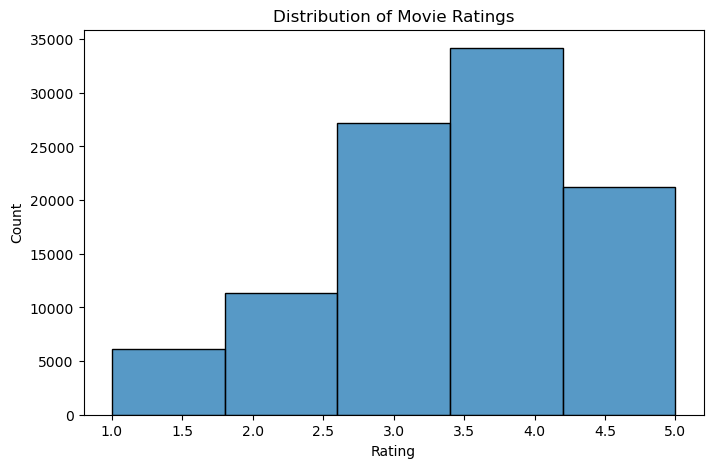

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(ratings["rating"], bins=5, kde=False)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Movie Ratings")
plt.show()

Number of unique users: 943
Number of unique movies: 1682


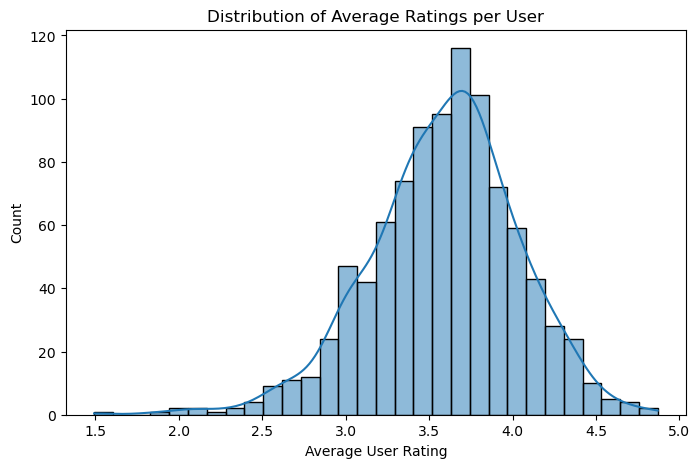

In [29]:
print(f"Number of unique users: {merged['user_id'].nunique()}")
print(f"Number of unique movies: {merged['movie_id'].nunique()}")

user_avg_ratings = merged.groupby("user_id")["rating"].mean()
plt.figure(figsize=(8,5))
sns.histplot(user_avg_ratings, bins=30, kde=True)
plt.xlabel("Average User Rating")
plt.ylabel("Count")
plt.title("Distribution of Average Ratings per User")
plt.show()

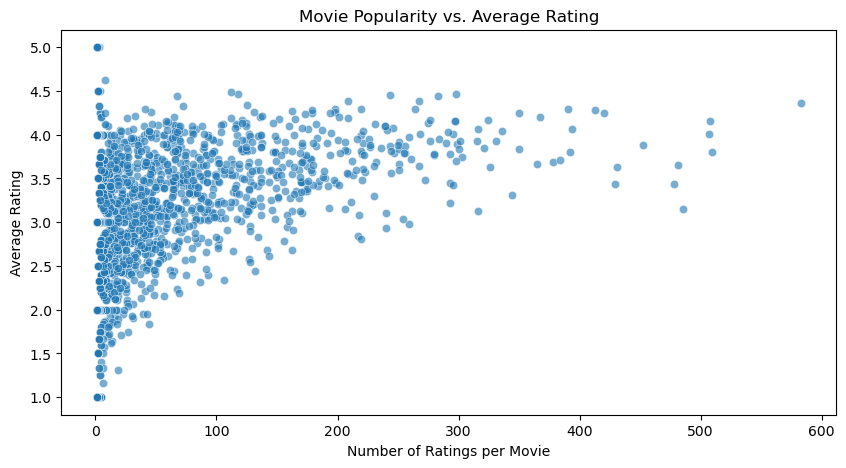

In [30]:
movie_ratings = merged.groupby("movie_id")["rating"].agg(["count", "mean"])
plt.figure(figsize=(10,5))
sns.scatterplot(x=movie_ratings["count"], y=movie_ratings["mean"], alpha=0.6)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Average Rating")
plt.title("Movie Popularity vs. Average Rating")
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_32980\329612625.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette="viridis")


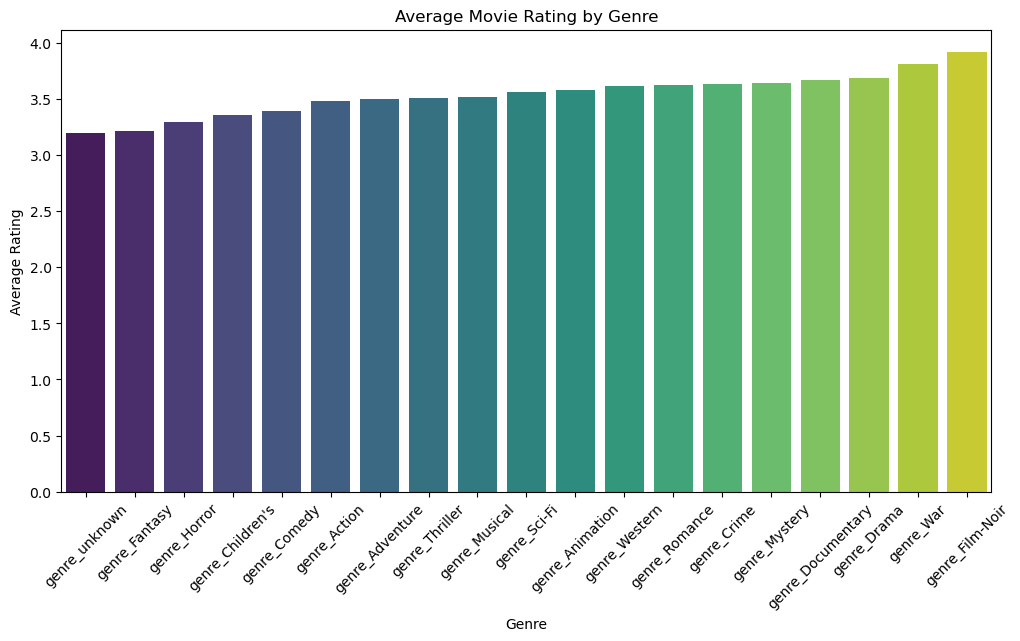

In [42]:
# Select only genre columns
genre_columns = [col for col in merged.columns if col.startswith("genre_")]

plt.figure(figsize=(12, 6))
genre_avg_rating = merged.melt(id_vars=["movie_id", "rating"], value_vars=genre_columns)
genre_avg_rating = genre_avg_rating[genre_avg_rating["value"] == 1].groupby("variable")["rating"].mean().sort_values()

sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.title("Average Movie Rating by Genre")
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_32980\4266486848.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index.str.replace("genre_", ""), y=genre_counts.values, palette="coolwarm")


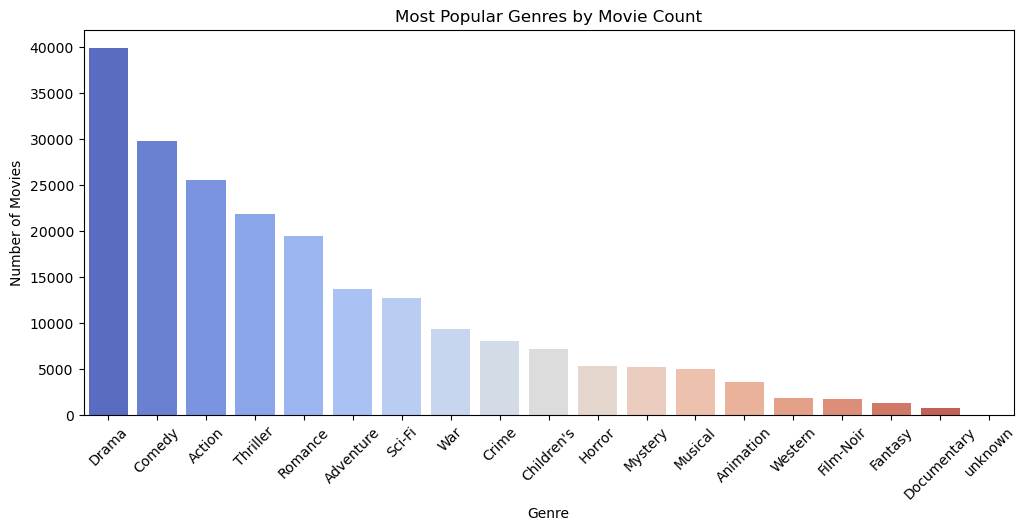

In [43]:
# Count the number of movies per genre
genre_counts = merged[genre_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=genre_counts.index.str.replace("genre_", ""), y=genre_counts.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Most Popular Genres by Movie Count")
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_32980\3214156335.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_user_counts.index, y=genre_user_counts.values, palette="viridis")


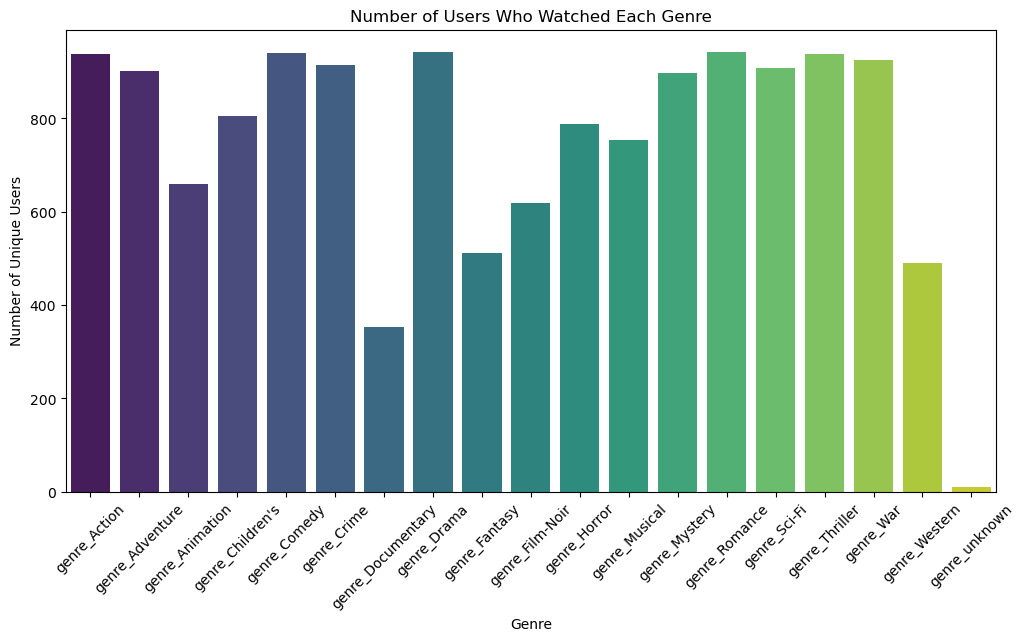

In [44]:
# Melt the dataset to map genres to ratings and user_id
genre_ratings = merged.melt(id_vars=["user_id", "rating"], value_vars=genre_columns)

genre_ratings

# Count the number of unique users who have watched each genre
genre_user_counts = genre_ratings[genre_ratings["value"] == 1].groupby("variable")["user_id"].nunique()

# Plot the result
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_user_counts.index, y=genre_user_counts.values, palette="viridis")

# Add labels and title
plt.xlabel("Genre")
plt.ylabel("Number of Unique Users")
plt.title("Number of Users Who Watched Each Genre")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

# Building Recommendation Engine

In [58]:
# Define Reader
reader = Reader(rating_scale=(1, 5))

# Load Data Directly into Surprise
data = Dataset.load_from_df(merged[["user_id", "movie_id", "rating"]], reader)

# Perform a Single Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

## User-based CF

In [68]:
# User-Based Collaborative Filtering
sim_options = {
    "name": "cosine",  # Similarity metric
    "user_based": True, # User-based filtering
}
model_user = KNNBasic(sim_options=sim_options)
model_user.fit(trainset)

# Predict on Test Set
predictions = model_user.test(testset)

# Evaluate Model Performance
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0158
MAE:  0.8029


## Item-based CF

In [69]:
sim_options = {
    "name": "cosine",
    "user_based": False, # Item-based filtering
}
model_item = KNNBasic(sim_options=sim_options)
model_item.fit(trainset)

predictions = model_item.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0254
MAE:  0.8085


## SVD

In [64]:
# Train SVD Model
svd_model = SVD()
svd_model.fit(trainset)

# Predict on Test Set
predictions = svd_model.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9347
MAE:  0.7361


## NMF

In [65]:
nmf_model = NMF()
nmf_model.fit(trainset)

predictions = nmf_model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9594
MAE:  0.7539


In [66]:
def get_recommendations(user_id, model, movie_df, num_recommendations=10):
    '''function getting recommendation'''
    # Get all movie IDs
    all_movie_ids = movie_df["movie_id"].unique()

    # Predict ratings for unseen movies
    predictions = [model.predict(user_id, movie_id) for movie_id in all_movie_ids]

    # Sort by highest predicted rating
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:num_recommendations]

    # Get movie titles
    recommended_movies = [movie_df[movie_df["movie_id"] == pred.iid]["title"].values[0] for pred in recommendations]

    return recommended_movies

In [70]:
recommended_movies = get_recommendations(user_id=1, model=model_user, movie_df=merged)
print(recommended_movies)

['Prefontaine (1997)', 'Santa with Muscles (1996)', 'Boys, Les (1997)', 'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 'Golden Earrings (1947)', 'Star Kid (1997)', 'Hugo Pool (1997)', "Someone Else's America (1995)", 'Entertaining Angels: The Dorothy Day Story (1996)']


In [71]:
recommended_movies = get_recommendations(user_id=1, model=model_item, movie_df=merged)
print(recommended_movies)

['Ill Gotten Gains (1997)', 'Amadeus (1984)', 'Groundhog Day (1993)', 'B. Monkey (1998)', "Mat' i syn (1997)", 'Sliding Doors (1998)', 'Hot Shots! Part Deux (1993)', 'Truth About Cats & Dogs, The (1996)', 'Dolores Claiborne (1994)', "Monty Python's Life of Brian (1979)"]


In [72]:
recommended_movies = get_recommendations(user_id=1, model=svd_model, movie_df=merged)
print(recommended_movies)

['Wrong Trousers, The (1993)', 'Duck Soup (1933)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Empire Strikes Back, The (1980)', 'High Noon (1952)', 'As Good As It Gets (1997)', 'Big Sleep, The (1946)', 'Rear Window (1954)', 'Star Wars (1977)', 'Delicatessen (1991)']


In [73]:
recommended_movies = get_recommendations(user_id=1, model=nmf_model, movie_df=merged)
print(recommended_movies)

['Boys, Les (1997)', 'Faust (1994)', 'Aiqing wansui (1994)', 'World of Apu, The (Apur Sansar) (1959)', 'Angel Baby (1995)', 'They Made Me a Criminal (1939)', 'Butcher Boy, The (1998)', "Some Mother's Son (1996)", 'Whole Wide World, The (1996)', 'Frisk (1995)']


From RMSE and MAE, the best model is SVD, NMF, User-based CF, and Item-based CF consecutively.

# Fine-tuning

## User-based CF

In [85]:
# Define parameter grid for User-Based CF
param_grid_user = {
    'k': [10, 20, 40, 60],  # Number of neighbors
    'min_k': [1, 3, 5],  # Minimum neighbors
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [True]  # User-Based Filtering
    }
}

# Perform Grid Search for User-Based CF
gs_user = GridSearchCV(KNNBasic, param_grid_user, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_user.fit(data)

# Print the best parameters and scores for User-Based CF
print("Best User-Based CF RMSE Score:", gs_user.best_score['rmse'])
print("Best User-Based CF MAE Score:", gs_user.best_score['mae'])
print("Best User-Based CF Parameters:", gs_user.best_params['rmse'])

Best User-Based CF RMSE Score: 1.0175352119733183
Best User-Based CF MAE Score: 0.8090270181564354
Best User-Based CF Parameters: {'k': 60, 'min_k': 3, 'sim_options': {'name': 'pearson', 'user_based': True}}


In [86]:
# Train KNN with the best parameters for User-Based CF
best_knn_user = KNNBasic(k=gs_user.best_params['rmse']['k'],
                          min_k=gs_user.best_params['rmse']['min_k'],
                          sim_options=gs_user.best_params['rmse']['sim_options'])
best_knn_user.fit(trainset)

# Evaluate the fine-tuned User-Based CF model
predictions_user = best_knn_user.test(testset)
rmse_user = accuracy.rmse(predictions_user)
mae_user = accuracy.mae(predictions_user)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0084
MAE:  0.8018


## Item-based CF

In [87]:
# Define parameter grid for Item-Based CF
param_grid_item = {
    'k': [10, 20, 40, 60],  # Number of neighbors
    'min_k': [1, 3, 5],  # Minimum neighbors
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [False]  # Item-Based Filtering
    }
}

# Perform Grid Search for Item-Based CF
gs_item = GridSearchCV(KNNBasic, param_grid_item, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_item.fit(data)

# Print the best parameters and scores for Item-Based CF
print("Best Item-Based CF RMSE Score:", gs_item.best_score['rmse'])
print("Best Item-Based CF MAE Score:", gs_item.best_score['mae'])
print("Best Item-Based CF Parameters:", gs_item.best_params['rmse'])

Best Item-Based CF RMSE Score: 1.0321214345186813
Best Item-Based CF MAE Score: 0.819719791153371
Best Item-Based CF Parameters: {'k': 60, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [88]:
# Train KNN with the best parameters for Item-Based CF
best_knn_item = KNNBasic(k=gs_item.best_params['rmse']['k'],
                          min_k=gs_item.best_params['rmse']['min_k'],
                          sim_options=gs_item.best_params['rmse']['sim_options'])
best_knn_item.fit(trainset)

# Evaluate the fine-tuned Item-Based CF model
predictions_item = best_knn_item.test(testset)
rmse_item = accuracy.rmse(predictions_item)
mae_item = accuracy.mae(predictions_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0220
MAE:  0.8060


## SVD

In [78]:
# Define parameter grid
param_grid = {
    'n_factors': [20, 50, 100],  # Number of latent factors
    'n_epochs': [20, 50, 100],  # Training iterations
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.05, 0.1]  # Regularization
}

# Perform Grid Search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

# Print best parameters
print("Best RMSE Score:", gs.best_score['rmse'])
print("Best MAE Score:", gs.best_score['mae'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE Score: 0.9200411829951456
Best MAE Score: 0.7266054582588293
Best Parameters: {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


In [79]:
# Train SVD with best parameters
best_svd = SVD(**gs.best_params['rmse'])
best_svd.fit(trainset)

# Evaluate the best model
predictions = best_svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9085
MAE:  0.7153


## NMF

In [81]:
# Define parameter grid
param_grid = {
    'n_factors': [10, 20, 50],
    'n_epochs': [50, 100, 200],
    'reg_pu': [0.02, 0.05, 0.1],
    'reg_qi': [0.02, 0.05, 0.1]
}

# Run GridSearch
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

# Print best parameters
print("Best RMSE Score:", gs.best_score['rmse'])
print("Best MAE Score:", gs.best_score['mae'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE Score: 0.9321796279709721
Best MAE Score: 0.739526677445402
Best Parameters: {'n_factors': 50, 'n_epochs': 200, 'reg_pu': 0.1, 'reg_qi': 0.1}


In [82]:
# Train with best params
best_nmf = NMF(**gs.best_params['rmse'])
best_nmf.fit(trainset)

# Evaluate
predictions = best_nmf.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.9164
MAE:  0.7259


0.7259456841376627

## Cold Start

For Cold Start (New Users with No Ratings), we can recommend popular movies (top-rated across all users)/ recommend content-based suggestions based on genres that user interested, we can ask them to pick when signing up ac account/ use demographic-based recommendations if user data available.

## Hybrid Recommender

### Diagram
User Input (User ID) → Collaborative Filtering (SVD & NMF) → Popularity-Based Model → Hybrid Recommendation Engine (Merging & Weighting) → Final Movie Recommendations

### Explaination
- User Input (User ID): The system receives a user ID for whom recommendations need to be generated.
- Collaborative Filtering (SVD & NMF):
The SVD model predicts ratings for movies the user hasn't rated based on latent factors derived from matrix factorization.
The NMF model does the same but uses non-negative constraints to learn user and item features.
Both models generate a ranked list of recommended movies.
- Popularity-Based Model: This model ranks movies based on overall popularity (e.g., average ratings, number of ratings) and provides a baseline recommendation for new users or as a supplement to CF-based recommendations.
- Hybrid Recommendation Engine (Merging & Weighting):
The top-ranked movies from SVD and NMF are combined.
A weight is applied to balance the influence of CF models and popularity-based recommendations.
The final recommendation list is sorted based on weighted scores.
- Final Movie Recommendations: The system returns the top recommended movies, including their titles and predicted relevance scores, to the user.

In [97]:
popular_items = merged.groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(5).index.tolist()

def get_movie_name(movie_id):
    # Map movie_id to movie name using your DataFrame
    movie_name = merged[merged['movie_id'] == movie_id]['title'].values
    return movie_name[0] if len(movie_name) > 0 else f"Movie {movie_id}"

def hybrid_recommend(user_id, svd_model, nmf_model, trainset, top_n=10):
    # Get top N recommendations using SVD
    svd_recommendations = [svd_model.predict(user_id, movie_id) for movie_id in trainset.all_items()]
    svd_recommendations_sorted = sorted(svd_recommendations, key=lambda x: x.est, reverse=True)[:top_n]
    
    # Get top N recommendations using NMF
    nmf_recommendations = [nmf_model.predict(user_id, movie_id) for movie_id in trainset.all_items()]
    nmf_recommendations_sorted = sorted(nmf_recommendations, key=lambda x: x.est, reverse=True)[:top_n]
    
    # Combine SVD and NMF recommendations (taking top N from both)
    hybrid_recommendations = [rec.iid for rec in svd_recommendations_sorted[:int(top_n / 2)]] + \
                             [rec.iid for rec in nmf_recommendations_sorted[:int(top_n / 2)]]
    
    # Combine with popular items and apply weights
    hybrid_recommendations.extend(popular_items[:2])  # Adding top popular items
    
    # Example: Weighted by popularity
    weighted_recommendations = []
    for item in hybrid_recommendations:
        weighted_recommendations.extend([item] * int(len(hybrid_recommendations) / 3))  # Weighting recommendations
    
    # Get movie names for the recommendations
    recommended_movie_names = [get_movie_name(movie_id) for movie_id, _ in Counter(weighted_recommendations).most_common(top_n)]
    
    return recommended_movie_names

In [98]:
user_id = 1
recommendations = hybrid_recommend(user_id, svd_model, nmf_model, trainset, top_n=10)

print(f"Top recommendations for user '{user_id}':")
for movie_name in recommendations:
    print(f"Movie: {movie_name}")

Top recommendations for user '1':
Movie: Wrong Trousers, The (1993)
Movie: Duck Soup (1933)
Movie: Wallace & Gromit: The Best of Aardman Animation (1996)
Movie: Empire Strikes Back, The (1980)
Movie: High Noon (1952)
Movie: They Made Me a Criminal (1939)
Movie: Faust (1994)
Movie: Boys, Les (1997)
Movie: World of Apu, The (Apur Sansar) (1959)
Movie: Aiqing wansui (1994)


## Approach:
The goal of this project was to build a movie recommendation system using various collaborative filtering techniques and evaluate their performance. The primary focus was to implement different algorithms for movie recommendation and explore ways to optimize the models for better accuracy.

## Data:

From the EDA, ratings distribution seems to be left-skewed. The less popular movies have higher ratings variance than popular movies. The average movie ratings per genre seems to be close for each genre, the range is from 3.3 to 4. The 3 most produced movies genre includes Drama, Comedy, Action. 
<br>
The data was split into a training and test set using a 80-20 split for evaluation purposes.

## Collaborative Filtering Models:
- User-based Collaborative Filtering (KNN): This method uses the ratings of similar users to predict movie ratings for a specific user. A cosine similarity measure was used to calculate similarity between users.
- Item-based Collaborative Filtering (KNN): In this method, the similarity between items (movies) was calculated, and recommendations were made based on the most similar items to those a user has rated.
- Matrix Factorization Models (SVD & NMF): These techniques were applied for recommendation. The SVD model decomposes the user-item matrix to find latent features that explain the ratings. The NMF model is another matrix factorization technique that is used to uncover hidden factors in the data.

## Optimizations:
Several optimization techniques were applied to improve the recommendation models:

1. Parameter Tuning:
For SVD, grid search was used to fine-tune parameters like the number of latent factors (n_factors), regularization terms (reg_all, reg_bias), and learning rate. This tuning helped improve both RMSE and MAE for SVD.

2. Hybrid Model:
A hybrid model combining SVD and NMF was used to enhance the recommendation process. This hybrid model was designed to balance collaborative filtering with item popularity and improve recommendation coverage and diversity.

3. Handling Cold Start:
A solution to the cold start problem was implemented by incorporating popular items into the hybrid model. This helps ensure that new users or items, with limited data, still receive meaningful recommendations by leveraging global item popularity.

4. Weighted Recommendations:
In the hybrid model, weighted recommendations were generated to prioritize the best-performing models (SVD and NMF) while still including some level of popular items to prevent under-recommendation.

## Evaluation:

The models were evaluated using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). These metrics were calculated to determine the accuracy of the recommendations by comparing the predicted ratings to the actual ratings. 

## RMSE (Root Mean Squared Error):
1. based models
    - SVD RMSE: 0.9347
    - NMF RMSE: 0.9594
    - User-based CF RMSE: 1.0158
    - Item-based CF RMSE: 1.0254
<br>
The lower the RMSE value, the better the model's prediction accuracy. From the results, SVD outperforms both NMF and KNN-based models (user and item-based CF) in terms of RMSE.
2. fine-tuned models
    - SVD RMSE: 0.9085
    - NMF RMSE: 0.9164
    - User-based CF RMSE: 1.0084
    - Item-based CF RMSE: 1.0220
<br>
After fine-tuned, all the models have a better accuracies. Still, the performance order of the models stay the same.

## MAE (Mean Absolute Error):
1. based models:
    - SVD MAE: 0.7361
    - NMF MAE: 0.7539
    - User-based CF MAE: 0.8029
    - Item-based CF MAE: 0.8085
<br>
Similar to RMSE, lower MAE values indicate better model performance. SVD again outperforms both NMF and KNN-based methods in terms of MAE.
2. fine-tuned models
    - SVD RMSE: 0.7153
    - NMF RMSE: 0.7259
    - User-based CF RMSE: 0.8018
    - Item-based CF RMSE: 0.8060
After fine-tuned, all the models have a better accuracies. Still, the performance order of the models stay the same.

## Final Observations:
- SVD showed the best overall performance based on both RMSE and MAE.
- NMF performed slightly worse but was still an effective model for matrix factorization-based recommendations.
- KNN-based models (user and item-based CF) had relatively higher RMSE and MAE scores, indicating that matrix factorization models were better suited for this particular dataset.
- The hybrid model combining SVD, NMF, and popular items showed promise in diversifying the recommendations, especially for handling the cold start problem.